# Preparing Model

## library installs

In [ ]:
!pip install diffusers hugchat transformers accelerate safetensors -q
!pip install git+https://github.com/huggingface/diffusers -q
!pip install ipywidgets -q
!pip install invisible_watermark -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Imports

In [ ]:
from ipywidgets import interactive, widgets
from IPython.display import HTML, Javascript, Image, display
from google.colab.output import eval_js
import base64
from diffusers import StableDiffusionXLPipeline
import torch


pipe = StableDiffusionXLPipeline.from_pretrained("segmind/SSD-1B", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.30.0.dev0",
  "_name_or_path": "segmind/SSD-1B",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## Recorder Creation

In [ ]:
js = Javascript(
    """
    async function recordAudio() {
      const div = document.createElement('div');
      const audio = document.createElement('audio');
      const strtButton = document.createElement('button');
      const stopButton = document.createElement('button');

      strtButton.textContent = 'Start Recording';
      stopButton.textContent = 'Stop Recording';

      document.body.appendChild(div);
      div.appendChild(strtButton);
      div.appendChild(audio);

      const stream = await navigator.mediaDevices.getUserMedia({audio:true});
      let recorder = new MediaRecorder(stream);

      audio.style.display = 'block';
      audio.srcObject = stream;
      audio.controls = true;
      audio.muted = true;

      await new Promise((resolve) => strtButton.onclick = resolve);
        strtButton.replaceWith(stopButton);
        recorder.start();

      await new Promise((resolve) => stopButton.onclick = resolve);
        recorder.stop();
        let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
        let arrBuff = await recData.data.arrayBuffer();
        stream.getAudioTracks()[0].stop();
        div.remove()

        let binaryString = '';
        let bytes = new Uint8Array(arrBuff);
        bytes.forEach((byte) => { binaryString += String.fromCharCode(byte)});

      const url = URL.createObjectURL(recData.data);
      const player = document.createElement('audio');
      player.controls = true;
      player.src = url;
      document.body.appendChild(player);

    return btoa(binaryString)

          };
          """
)

# Creating Speech to text function

In [ ]:
API_KEY_ASSEMBLYAI = 'b0fc26e7ff234fde80e885df31471f5c'

In [ ]:
import requests
import time



upload_endpoint = 'https://api.assemblyai.com/v2/upload'
transcript_endpoint = 'https://api.assemblyai.com/v2/transcript'

headers_auth_only = {'authorization': API_KEY_ASSEMBLYAI}

headers = {
    "authorization": API_KEY_ASSEMBLYAI,
    "content-type": "application/json"
}

CHUNK_SIZE = 5_242_880  # 5MB


def upload(filename):
    def read_file(filename):
        with open(filename, 'rb') as f:
            while True:
                data = f.read(CHUNK_SIZE)
                if not data:
                    break
                yield data

    upload_response = requests.post(upload_endpoint, headers=headers_auth_only, data=read_file(filename))
    return upload_response.json()['upload_url']


def transcribe(audio_url):
    transcript_request = {
        'audio_url': audio_url
    }

    transcript_response = requests.post(transcript_endpoint, json=transcript_request, headers=headers)
    return transcript_response.json()['id']


def poll(transcript_id):
    polling_endpoint = transcript_endpoint + '/' + transcript_id
    polling_response = requests.get(polling_endpoint, headers=headers)
    return polling_response.json()


def get_transcription_result_url(url):
    transcribe_id = transcribe(url)
    while True:
        data = poll(transcribe_id)
        if data['status'] == 'completed':
            return data, None
        elif data['status'] == 'error':
            return data, data['error']

        print("waiting for 30 seconds")
        time.sleep(30)


def save_transcript(url, title):
    data, error = get_transcription_result_url(url)

    if data:
        filename = title + '.txt'
        print(data)
        with open(filename, 'w') as f:
            f.write(data['text'])
        print('Transcript saved')
    elif error:
        print("Error!!!", error)

In [ ]:
title = 'autobots'

filename = "autobots.mp3"

audio_url = upload(filename)

save_transcript(audio_url, title)

waiting for 30 seconds
{'id': '046cca1e-0758-40ff-96a6-6c7db7c16c41', 'language_model': 'assemblyai_default', 'acoustic_model': 'assemblyai_default', 'language_code': 'en_us', 'status': 'completed', 'audio_url': 'https://cdn.assemblyai.com/upload/2cc6a93e-5592-4e2f-8407-78ea5e4f158b', 'text': 'Wide shot angle of autobots fighting Decepticons in fallen Cybertron.', 'words': [{'start': 280, 'end': 504, 'text': 'Wide', 'confidence': 0.67645, 'speaker': None}, {'start': 504, 'end': 864, 'text': 'shot', 'confidence': 0.57155, 'speaker': None}, {'start': 926, 'end': 1230, 'text': 'angle', 'confidence': 0.77966, 'speaker': None}, {'start': 1270, 'end': 1470, 'text': 'of', 'confidence': 1.0, 'speaker': None}, {'start': 1510, 'end': 2142, 'text': 'autobots', 'confidence': 0.94706, 'speaker': None}, {'start': 2206, 'end': 2590, 'text': 'fighting', 'confidence': 0.99987, 'speaker': None}, {'start': 2630, 'end': 3406, 'text': 'Decepticons', 'confidence': 0.54381, 'speaker': None}, {'start': 3478, 

## Saving to variable and a .txt file

In [ ]:
file = open(title + '.txt', 'r')
content = file.read()
print(content)


file.close()

Wide shot angle of autobots fighting Decepticons in fallen Cybertron.


## Displaying recorder

In [ ]:
display(js)
output = eval_js('recordAudio({})')
with open('audio.wav', 'wb') as file:
    binary = base64.b64decode(output)
    file.write(binary)
print('Recording saved to:', file.name)

<IPython.core.display.Javascript object>

Recording saved to: audio.wav


In [ ]:
print(content)

Wide shot angle of autobots fighting Decepticons in fallen Cybertron.


# Creating image

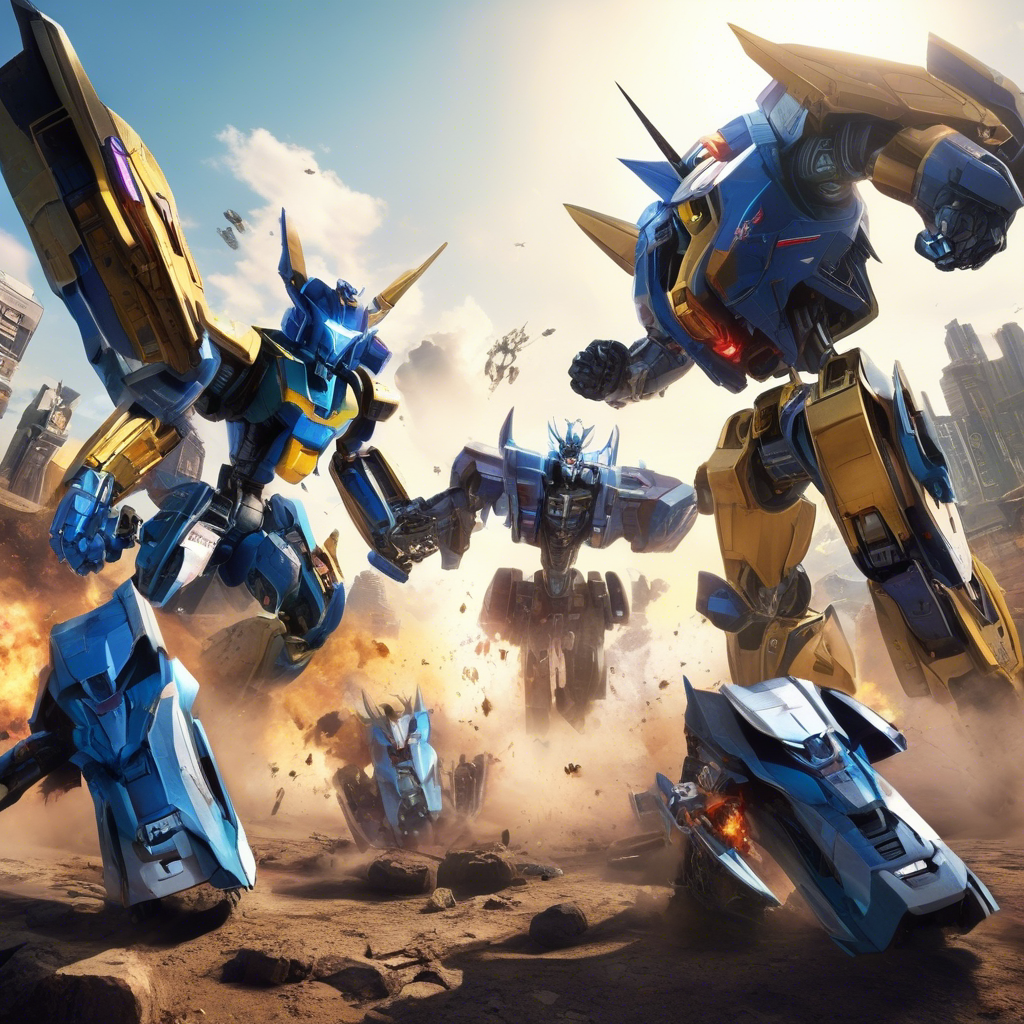

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
generated_image = None
image_display = display("", display_id=True)

def generate_image(button):
    global generated_image

    image_style = style_dropdown.value
    image_quality = quality_dropdown.value
    render = render_dropdown.value
    angle = angle_dropdown.value
    lighting = lighting_dropdown.value
    background = background_dropdown.value
    device = device_dropdown.value
    emotion = emotion_dropdown.value

    prompt = f"A stunning {image_style}, {image_quality} shot of {content} captured in {device} using {angle} and rendered by {render}, illuminated by {lighting} light, with {emotion} emotions in a {background} background setting."

    neg_prompt = "ugly, blurry, poor quality, deformed structure, very bad lighting, bad colouring, noise"
    generated_image = pipe(prompt=prompt, negative_prompt=neg_prompt).images[0]

    generated_image.save("generated_image.png")
    final_image_path = "generated_image.png"
    image_display.update(Image(filename=final_image_path))

image_style_options = ["Sci-fi", "photorealistic", "low poly", "cinematic", "cartoon", "graffiti", "sketching"]
image_quality_options = ["High resolution", "8K", "clear", "heavy detailed", "beautiful", "realistic+++", "hyper detailed", "masterpiece"]
render_options = ["Pixar","Octane", "real-time ray tracing", "Christopher Nolan", "James Cameron", "unreal engine", "unity" ]
angle_options = ["Wide-angle lens", "full shot", "Top angle" "Telephoto lens", "Prime lens", "Zoom lens", "Macro lens", "Fisheye lens", "Tilt-shift lens", "Portrait lens", "Anamorphic lens", "Cinematic lens", "Fixed focal length lens", "Variable focal length lens"]
lighting_options = ["Soft", "ambient", "ring" "light", "neon", "Natural", "Soft", "Harsh", "Dramatic", "Backlit", "Studio"]
background_options = ["outdoor", "indoor", "space", "nature", "sci-fi", "neon", "abstract"]
device_options = ["Go Pro", "Iphone 15", "Canon EOS R5","Nikon Z7", "Sony F950", "Drone", "CCTV",]
emotion_options = ["Happy", "Sad", "Angry", "Mysterious", "Surprised", "Annoyed", "Neutral", "dreamy", "nostalgic"]

style_dropdown = widgets.Dropdown(options=image_style_options, description="Style:")
quality_dropdown = widgets.Dropdown(options=image_quality_options, description="Quality:")
render_dropdown = widgets.Dropdown(options=render_options, description="Render by:")
angle_dropdown = widgets.Dropdown(options=angle_options, description="Angle:")
lighting_dropdown = widgets.Dropdown(options=lighting_options, description="Lighting:")
background_dropdown = widgets.Dropdown(options=background_options, description="Background:")
device_dropdown = widgets.Dropdown(options=device_options, description="Device:")
emotion_dropdown = widgets.Dropdown(options=emotion_options, description="Emotion:")

generate_button = widgets.Button(description="Generate Image")

generate_button.on_click(generate_image)

interactive_widget = widgets.VBox([
    style_dropdown, quality_dropdown, angle_dropdown, render_dropdown,
    lighting_dropdown, background_dropdown, device_dropdown, emotion_dropdown,
    generate_button
])

display(interactive_widget)
